# Part 1: Exploratory Data Analysis

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from datetime import timedelta
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import norm 
import math
from scipy import stats
from scipy.stats import t
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import svm, datasets

In [2]:
pd.reset_option('display.max_rows',None)

In [3]:
logins = pd.read_json('logins.json')

In [4]:
logins.shape

(93142, 1)

In [5]:
logins.dtypes

login_time    datetime64[ns]
dtype: object

In [6]:
logins['count'] = 1

In [7]:
logins.set_index('login_time',inplace=True)

In [8]:
logins.head()

count
login_time                
1970-01-01 20:13:18      1
1970-01-01 20:16:10      1
1970-01-01 20:16:37      1
1970-01-01 20:16:36      1
1970-01-01 20:26:21      1

In [9]:
log_15 = logins.resample('15min').sum()

data quality issue: 
* some times are out of order, listing a random 1970-01-02 log in time in the middle of 1970-01-01 times, similar thing happening with 03 and 02 -- might continue through the dataset? 
* There are 877 duplicates 

* not sure these are considered data quality issues -- duplicates aren't a problem because they are just showing multiple logins occuring at the same time 

In [10]:
log_15

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1
...                    ...
1970-04-13 17:45:00      5
1970-04-13 18:00:00      5
1970-04-13 18:15:00      2
1970-04-13 18:30:00      7
1970-04-13 18:45:00      6

[9788 rows x 1 columns]

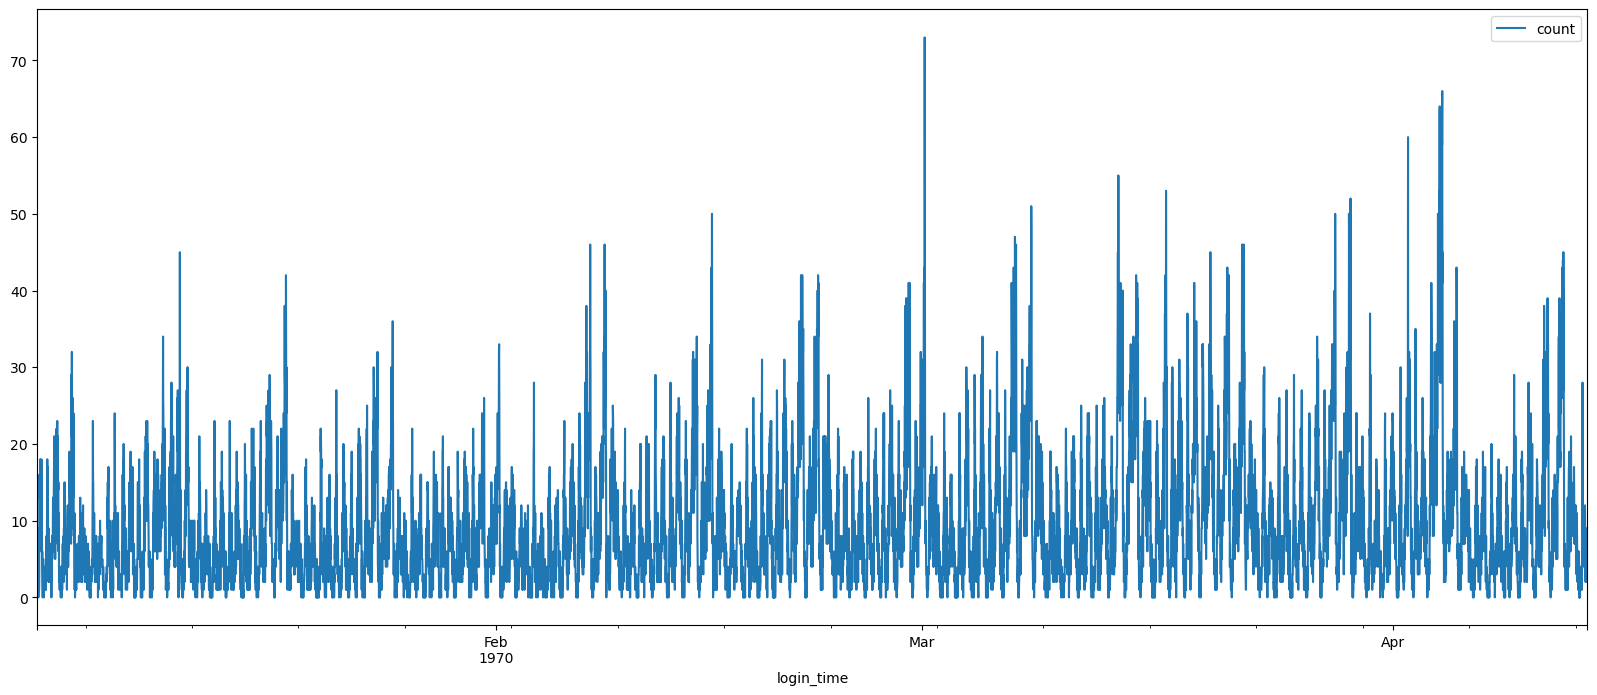

In [11]:
log_15.plot(figsize=(20,8))
plt.show()

In [12]:
log_15['Day_of_Month'] = log_15.index.day
log_15['Day_of_Week'] = log_15.index.weekday

In [13]:
log_15['time'] = log_15.index.time

data is a 4 month range (january - april). Looks like it is producing a sinusoidal trend with an increasing average towards the end 

In [14]:
log_15.describe()

count  Day_of_Month  Day_of_Week
count  9788.000000   9788.000000  9788.000000
mean      9.515938     14.569268     3.035554
std       8.328818      8.683342     2.012722
min       0.000000      1.000000     0.000000
25%       3.000000      7.000000     1.000000
50%       7.000000     14.000000     3.000000
75%      13.000000     22.000000     5.000000
max      73.000000     31.000000     6.000000

Looks like the median of the data is 7 logins per 15 minute interval, the mean value is a bit higher at 9.52 -- probably being pulled up by the higher average towards to the end of the 4-month range. 

In [15]:
log_15.loc[log_15['count']==73]

count  Day_of_Month  Day_of_Week      time
login_time                                                     
1970-03-01 04:30:00     73             1            6  04:30:00

Max number of logins occured on march 1st ... at 4:30am ? 

In [16]:
#let's look at the overall stats for the dataset as a whole 
log_15['Day_of_Month'].describe()

count    9788.000000
mean       14.569268
std         8.683342
min         1.000000
25%         7.000000
50%        14.000000
75%        22.000000
max        31.000000
Name: Day_of_Month, dtype: float64

Our average login days are occuring mid month -- 14.57th day of the month, median is 14. Tells us that a majority of logins are occuring towards the end of the month, lifting the mean up. (Not necessarily saying that the max login days are occuring at the end of the month, but a majority of logins are collectively occuring towards the end of the month)

In [17]:
log_15['Day_of_Month'].value_counts().describe()

count     31.000000
mean     315.741935
std       60.881835
min      192.000000
25%      288.000000
50%      288.000000
75%      384.000000
max      384.000000
Name: Day_of_Month, dtype: float64

In [18]:
log_15['Day_of_Month'].value_counts()

11    384
3     384
4     384
5     384
6     384
7     384
8     384
9     384
10    384
2     384
12    384
13    364
1     304
28    288
27    288
22    288
26    288
25    288
24    288
23    288
16    288
21    288
20    288
19    288
18    288
17    288
15    288
14    288
29    192
30    192
31    192
Name: Day_of_Month, dtype: int64

In [19]:
log_15['Day_of_Week'].describe()

count    9788.000000
mean        3.035554
std         2.012722
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max         6.000000
Name: Day_of_Week, dtype: float64

In [20]:
log_15['Day_of_Week'].value_counts()

4    1440
5    1440
6    1440
0    1420
3    1360
1    1344
2    1344
Name: Day_of_Week, dtype: int64

Pandas date time index day of the week function denotes Monday as 0 and Sunday as 6. We have logins occuring on Mondays in our dataset. Majority of logins are occuring Friday, Saturday, Sunday -- weekday logins are not much further behind these though. 

In [21]:
#create a dataset that is only peak values -- we'll use 99th percentile as peak.
peak = np.quantile(log_15['count'],0.99)

In [22]:
peakdf = log_15.loc[log_15['count']>= peak]

In [23]:
peakdf

count  Day_of_Month  Day_of_Week      time
login_time                                                     
1970-01-11 04:45:00     45            11            6  04:45:00
1970-01-18 02:15:00     38            18            6  02:15:00
1970-01-18 04:15:00     42            18            6  04:15:00
1970-02-06 22:30:00     38             6            4  22:30:00
1970-02-07 04:15:00     38             7            5  04:15:00
...                    ...           ...          ...       ...
1970-04-12 03:00:00     39            12            6  03:00:00
1970-04-12 03:15:00     43            12            6  03:15:00
1970-04-12 03:45:00     38            12            6  03:45:00
1970-04-12 04:00:00     44            12            6  04:00:00
1970-04-12 04:45:00     45            12            6  04:45:00

[107 rows x 4 columns]

In [24]:
peakdf['Day_of_Month'].describe()

count    107.000000
mean      13.570093
std        9.046121
min        1.000000
25%        4.500000
50%       12.000000
75%       21.000000
max       29.000000
Name: Day_of_Month, dtype: float64

looks like most logins are occuring closer to the middle of the month -- average = 13.57th day of the month / median = 12th day of the month Higher mean that median telling us that we are still having a collective majority of logins occuring towards the end of the month. 

In [25]:
peakdf['Day_of_Month'].value_counts().describe()

count    21.000000
mean      5.095238
std       3.871754
min       1.000000
25%       2.000000
50%       5.000000
75%       7.000000
max      18.000000
Name: Day_of_Month, dtype: float64

In [26]:
peakdf['Day_of_Month'].value_counts()

4     18
22     9
29     9
7      7
8      7
21     7
1      6
15     6
28     6
13     5
12     5
18     3
17     3
3      3
11     3
14     2
27     2
6      2
5      2
19     1
10     1
Name: Day_of_Month, dtype: int64

In [27]:
peakdf.loc[peakdf['Day_of_Month'] == 4] 

count  Day_of_Month  Day_of_Week      time
login_time                                                     
1970-04-04 00:15:00     39             4            5  00:15:00
1970-04-04 00:30:00     53             4            5  00:30:00
1970-04-04 00:45:00     50             4            5  00:45:00
1970-04-04 01:00:00     54             4            5  01:00:00
1970-04-04 01:15:00     63             4            5  01:15:00
1970-04-04 01:30:00     64             4            5  01:30:00
1970-04-04 01:45:00     56             4            5  01:45:00
1970-04-04 02:15:00     38             4            5  02:15:00
1970-04-04 03:00:00     47             4            5  03:00:00
1970-04-04 03:15:00     46             4            5  03:15:00
1970-04-04 04:15:00     40             4            5  04:15:00
1970-04-04 04:30:00     44             4            5  04:30:00
1970-04-04 04:45:00     59             4            5  04:45:00
1970-04-04 05:00:00     60             4            5  05:00:00
1970-04-04 05:15:00     59             4            5  05:15:00
1970-04-04 05:30:00     66             4            5  05:30:00
1970-04-04 05:45:00     41             4            5  05:45:00
1970-04-04 06:00:00     45             4            5  06:00:00

Max logins happening on the 4th but it looks like they are all consolidated to one single "4th day of the month". Meaning the 4th day of the month is not necessarily the highest trafficking day for each month, it was only the highest trafficked day in April. 

In [28]:
peakdf['Day_of_Week'].describe()

count    107.000000
mean       5.121495
std        1.096394
min        1.000000
25%        5.000000
50%        5.000000
75%        6.000000
max        6.000000
Name: Day_of_Week, dtype: float64

Pandas date time index day of the week function denotes Monday as 0 and Sunday as 6 -- the min here is 1, meaning we have no peak login days occuring on Mondays. Both our mean and median are around the 5th day, showing that our average peak day is occuring on Saturdays.  

Our average peak day for logins is Saturday but most of our peak days are occuring on Sundays -- overall, weekends are showing much more traffic than any day of the week. 

In [29]:
peakdf['Day_of_Week'].value_counts()

6    46
5    42
4    13
1     3
2     2
3     1
Name: Day_of_Week, dtype: int64

In [30]:
peakdf.loc[peakdf['Day_of_Week']==6]

count  Day_of_Month  Day_of_Week      time
login_time                                                     
1970-01-11 04:45:00     45            11            6  04:45:00
1970-01-18 02:15:00     38            18            6  02:15:00
1970-01-18 04:15:00     42            18            6  04:15:00
1970-02-08 03:15:00     46             8            6  03:15:00
1970-02-08 04:45:00     40             8            6  04:45:00
1970-02-15 04:00:00     43            15            6  04:00:00
1970-02-15 04:30:00     40            15            6  04:30:00
1970-02-15 04:45:00     50            15            6  04:45:00
1970-02-22 03:30:00     40            22            6  03:30:00
1970-02-22 04:15:00     42            22            6  04:15:00
1970-02-22 04:45:00     41            22            6  04:45:00
1970-02-22 05:00:00     40            22            6  05:00:00
1970-03-01 03:15:00     41             1            6  03:15:00
1970-03-01 04:00:00     43             1            6  04:00:00
1970-03-01 04:15:00     41             1            6  04:15:00
1970-03-01 04:30:00     73             1            6  04:30:00
1970-03-01 04:45:00     48             1            6  04:45:00
1970-03-08 02:15:00     38             8            6  02:15:00
1970-03-08 03:30:00     38             8            6  03:30:00
1970-03-08 04:30:00     43             8            6  04:30:00
1970-03-08 04:45:00     51             8            6  04:45:00
1970-03-08 05:00:00     47             8            6  05:00:00
1970-03-15 02:15:00     42            15            6  02:15:00
1970-03-15 04:00:00     41            15            6  04:00:00
1970-03-15 04:30:00     39            15            6  04:30:00
1970-03-22 01:30:00     46            22            6  01:30:00
1970-03-22 02:00:00     45            22            6  02:00:00
1970-03-22 04:00:00     46            22            6  04:00:00
1970-03-22 04:15:00     40            22            6  04:15:00
1970-03-22 04:30:00     45            22            6  04:30:00
1970-03-29 02:15:00     50            29            6  02:15:00
1970-03-29 02:30:00     43            29            6  02:30:00
1970-03-29 02:45:00     45            29            6  02:45:00
1970-03-29 03:15:00     38            29            6  03:15:00
1970-03-29 03:30:00     38            29            6  03:30:00
1970-03-29 04:15:00     41            29            6  04:15:00
1970-03-29 04:30:00     44            29            6  04:30:00
1970-03-29 04:45:00     52            29            6  04:45:00
1970-03-29 05:00:00     41            29            6  05:00:00
1970-04-05 04:00:00     43             5            6  04:00:00
1970-04-05 04:15:00     42             5            6  04:15:00
1970-04-12 03:00:00     39            12            6  03:00:00
1970-04-12 03:15:00     43            12            6  03:15:00
1970-04-12 03:45:00     38            12            6  03:45:00
1970-04-12 04:00:00     44            12            6  04:00:00
1970-04-12 04:45:00     45            12            6  04:45:00

Peak day of week being Sunday looks like a common occurence for each month. 

In [31]:
peakdf['time'].describe()

count          107
unique          34
top       04:45:00
freq            13
Name: time, dtype: object

34 unique times within the peak login dataset, top occuring is 4:45AM with 13 occurences

In [32]:
peakdf['time'].value_counts()

04:45:00    13
04:30:00    11
04:15:00     8
03:15:00     7
02:15:00     7
04:00:00     6
03:30:00     5
05:00:00     5
01:30:00     4
22:30:00     3
03:45:00     3
03:00:00     3
22:15:00     2
01:45:00     2
00:30:00     2
23:30:00     2
22:00:00     2
01:00:00     2
23:15:00     2
21:45:00     2
02:30:00     2
01:15:00     2
05:45:00     1
00:15:00     1
05:30:00     1
05:15:00     1
00:45:00     1
21:30:00     1
22:45:00     1
12:15:00     1
02:45:00     1
02:00:00     1
21:15:00     1
06:00:00     1
Name: time, dtype: int64

4am hour has the most amount of logins in the peak dataset

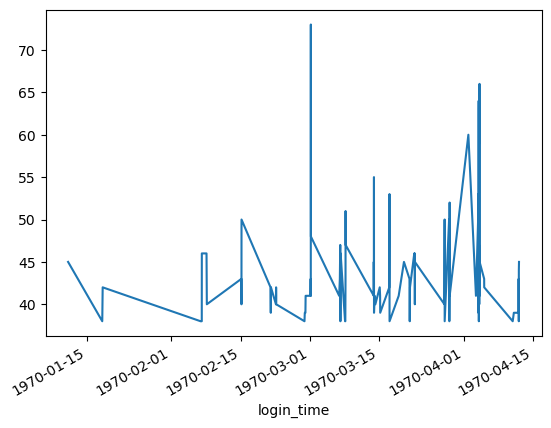

In [33]:
peakdf['count'].plot()
plt.show()

Average login counts for peak days are also increasing -- wondering what happened on 03-01 to make such a large peak.

In [34]:
# Let's zoom out a bit and look at the same plot by day 
log_day = logins.resample('D').sum()

In [35]:
log_day

count
login_time       
1970-01-01    112
1970-01-02    681
1970-01-03    793
1970-01-04    788
1970-01-05    459
...           ...
1970-04-09    818
1970-04-10   1009
1970-04-11   1352
1970-04-12   1409
1970-04-13    395

[103 rows x 1 columns]

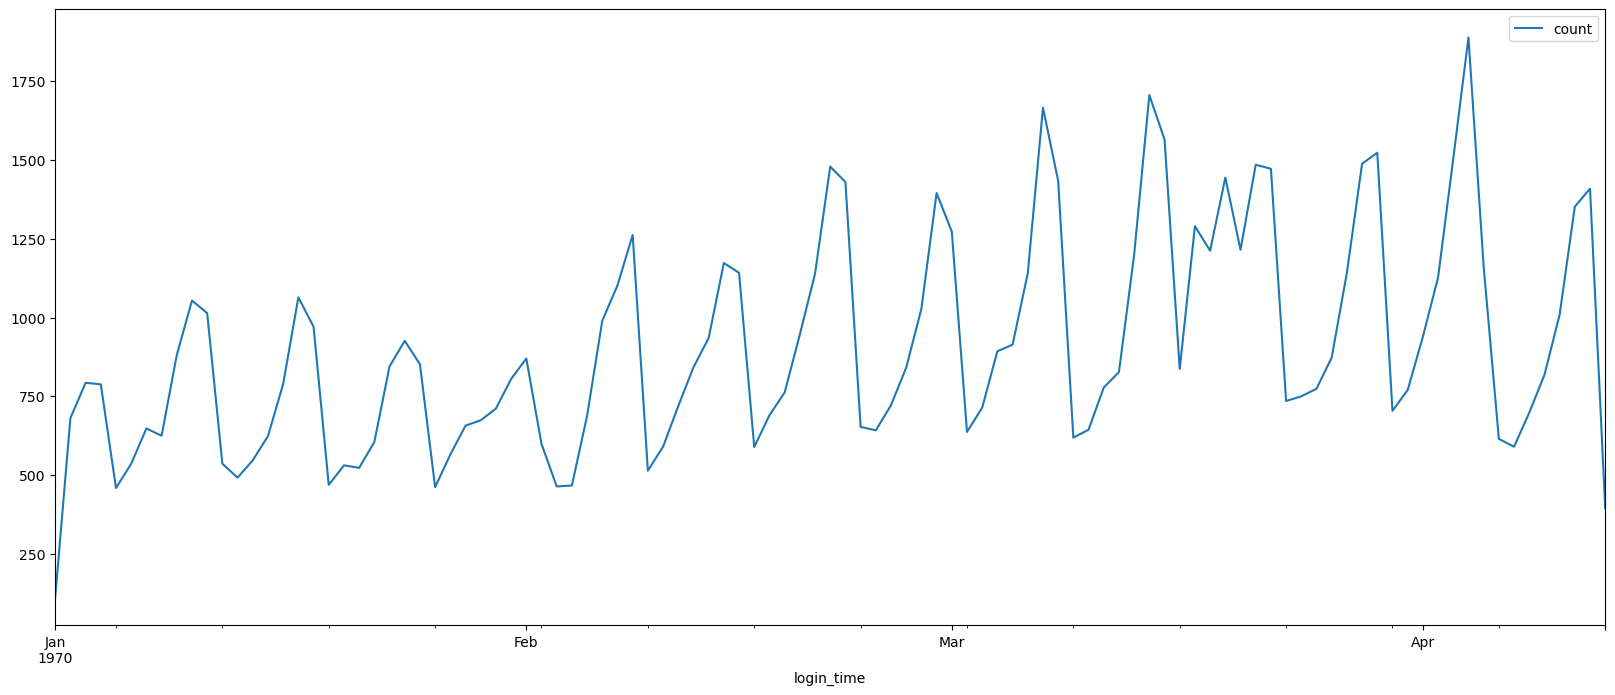

In [36]:
log_day.plot(figsize=(20,8))
plt.show()

This plot shows the increasing average a bit clearer. Trend seems to break at the end of our dataset by returning to lower lows but it looks like our dataset stops around 6:45pm on the last day of our dataset - could just not be accounting for a larger number of logins occuring at the end of the day?

## Part 1 Summary: 

#### Whole dataset: 

* Once graphed, data is showing a sinusoidal pattern. Potentially showing a reoccuring change throughout day/month. The average seems to be inceasing as time goes on. 
* Median number of logins = 7 / Mean = 9.5. Assuming the mean is being pulled up by the average increasing over time. 
* Greatest number of logins occured on 03-01-1970 with 73 logins occuring around 4:30AM. 
* Average number of logins are occuring mid-month : Mean = 14.57th day / Median = 14th day. Max values occur from a range of the 2nd day - 12th day of the month -- The mean is being pulled up due to a collective majority of logins occuring towards the end of the month. (after the 12th). 
* Average number of logins occuring the week are on Thursdays. Mean = Thursday/ Median = Thursday. Max number of logins occuring on Fridays, Saturdays, and Sundays. 

#### Peak dataset: 
* We created a subset of only peak values (values found in the 99th percentile). This dataset is a total of 107 values. 
* Most of our days where the peak number of logins are occuring are closer to the middle of the month. Mean = 13.57th day of the month / Median = 12th day of the month. With the max number of logins occuring on the 4th day of April -- there are 18 occurences here. 
* There are no peak logins occuring on Mondays
* Our peak login data for day of the week: Mean = Saturday/ Median = Sunday. Max = Sunday for each month. 
* Looks like most logins in our peak dataset are occuring within the 4th hour of the day (4AM).Minimum values for this were scattered throughout the early morning / times closer to 9PM/ and lunch hours (12PM). 

# Part 2: Experiment and Metrics Design 

*SEE 'ultimate_data_science_challenge.pdf' FOR MORE INSTRUCTION*

**1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**

I would use number of pickups and drop offs in either city as my key metric. 

**2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**

**a. how you will implement the experiment**

I would begin tracking metrics of no less than 100 drivers at least a month prior to announcing the proposal of reimbursement to all drivers. Early tracking will allow us to determine which city these drivers are typically servicing and gather totals for the number of pickups/drop offs they are completing prior to implementation of the change. It seems unrealistic that any driver would choose to work a shift long enough to cover both cities circadium rythms during the weekdays; because of this, I would focus on gathering confirmed dropoff and pickup data during the weekends -- when a driver is more likely to be traveling between either city. The confirmed dropoff and pickup data will include geolocation data that describes in which city these pickups and dropoffs are occuring. 

**b. what statistical test(s) you will conduct to verify the significance of the
observation**

Group drivers based on the city they most serviced prior to implementing toll reimbursement plan and then test for significance between the mean of pickup and drop offs that occurred prior to implementing the change and the mean of pickup and drop offs that occurred following the implementation of toll reimbursment. Since this is more than a single group I would run two separate t-tests -- one for pickups and one for dropoffs and do this once for the Gotham group and again for the Metropolis group. 

**c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.**

The means being significantly different from each other would tell us that implemennting toll reimbursement did in fact encourge drivers to service both cities. 

Would need to think about if drivers will always qualify for reimbursement or if they will only get it when they are actively driving for a customer? How will you account for drivers returning home after dropping off in the city they do not reside in? 

There must be drivers that already drive across the bridge with the current toll -- will introducing toll reimbursement cost the company more than it will profit them? 

Need to take into account weekends that are expected to be higher trafficked than normal -- holidays, events, etc. 


# Part 3: Predictive Modeling

In [37]:
df = pd.read_json('ultimate_data_challenge.json')

In [38]:
df.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYYMMDD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

User is considered 'retained' if their last trip occurred in the last 30 days. 

In [39]:
df.shape

(50000, 12)

In [40]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

We can impute the mean for missing values of avg_rating_of_driver and avg_rating_by_driver, we cannot assume missing values for phone. -- Will look into dropping this column. 

In [41]:
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(),inplace=True)

In [42]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(),inplace=True)

In [43]:
df.dropna(inplace=True)

In [44]:
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [45]:
df.shape

(49604, 12)

In [46]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

Want to change the signup_date and last_trip_date types to datetime objects. 

In [47]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [48]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [49]:
df['last_trip_date'].describe()

<ipython-input-49-0832a502f142>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['last_trip_date'].describe()


count                   49604
unique                    182
top       2014-06-29 00:00:00
freq                     2019
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [50]:
df['last_trip_date'].max()

Timestamp('2014-07-01 00:00:00')

In [51]:
#now create a function to change all 'last_trip_date' to either "active" or "inactive" so we can group our active drivers easily 

today = df['last_trip_date'].max()

def active_inactive(today,x): 
    if today - x <= timedelta(days = 30):
        return 'Active'
    else:
        return 'Inactive'

In [52]:
df['User_Activity'] = df['last_trip_date'].apply(lambda x: active_inactive(today,x))


In [53]:
df

city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct  \
0                  4.700000       1.10     2014-06-17   iPhone       15.4   
1                  5.000000       1.00     2014-05-05  Android        0.0   
2                  4.300000       1.00     2014-01-07   iPhone        0.0   
3                  4.600000       1.14     2014-06-29   iPhone       20.0   
4                  4.400000       1.19     2014-03-15  Android       11.8   
...                     ...        ...            ...      ...        ...   
49995              5.000000       1.00     2014-06-05   iPhone        0.0   
49996              4.601559       1.00     2014-01-25   iPhone        0.0   
49997              5.000000       1.00     2014-05-22  Android        0.0   
49998              3.000000       1.00     2014-01-15   iPhone        0.0   
49999              4.601559       1.00     2014-04-20  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  \
0                     True         46.2      3.67                   5.0   
1                    False         50.0      8.26                   5.0   
2                    False        100.0      0.77                   5.0   
3                     True         80.0      2.36                   4.9   
4                    False         82.4      3.13                   4.9   
...                    ...          ...       ...                   ...   
49995                False        100.0      5.63                   4.2   
49996                False          0.0      0.00                   4.0   
49997                 True        100.0      3.86                   5.0   
49998                False        100.0      4.58                   3.5   
49999                False          0.0      3.49                   5.0   

      User_Activity  
0            Active  
1          Inactive  
2          Inactive  
3            Active  
4          Inactive  
...             ...  
49995        Active  
49996      Inactive  
49997      Inactive  
49998      Inactive  
49999      Inactive  

[49604 rows x 13 columns]

In [54]:
active = df.loc[df['User_Activity']=='Active']

In [55]:
inactive = df.loc[df['User_Activity']=='Inactive']

In [56]:
df.shape

(49604, 13)

In [57]:
active.shape

(18671, 13)

In [58]:
inactive.shape

(30933, 13)

This is a classification problem -- our two potential labels are 'Active' or 'Inactive' -- we'll explore our data and then determine if any of these are significantly contributing to our final label determination. Our data is fairly unbalanced, we have a little more than half the amount of active members as we do inactive. 

In [59]:
df.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            49604.000000          49604.000000  49604.000000   
mean                 2.277256              4.601482      1.074991   
std                  3.793300              0.565227      0.222666   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.500000      1.000000   
50%                  1.000000              4.700000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  49604.000000  49604.000000  49604.000000          49604.000000  
mean       8.875314     60.883832      5.785418              4.777862  
std       19.989018     37.086239      5.669709              0.446220  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.700000    100.000000      6.930000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

* Looks like most of the trips are occuring during weekdays -- mean = ~60% for both groups


In [60]:
#Now let's take a look at factors that could be Active/Inactive contributors

active.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            18671.000000          18671.000000  18671.000000   
mean                 3.304804              4.593778      1.073834   
std                  4.985057              0.518625      0.162905   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.400000      1.000000   
50%                  2.000000              4.700000      1.000000   
75%                  4.000000              5.000000      1.090000   
max                125.000000              5.000000      4.500000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  18671.000000  18671.000000  18671.000000          18671.000000  
mean       9.165615     61.344208      5.113930              4.762740  
std       15.599652     29.512875      4.617779              0.328707  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     44.400000      2.560000              4.700000  
50%        0.000000     64.300000      3.730000              4.800000  
75%       13.300000     84.600000      5.890000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

In [61]:
inactive.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            30933.000000          30933.000000  30933.000000   
mean                 1.657033              4.606132      1.075689   
std                  2.655767              0.591542      0.251969   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.500000      1.000000   
50%                  1.000000              4.800000      1.000000   
75%                  2.000000              5.000000      1.000000   
max                 73.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  30933.000000  30933.000000  30933.000000          30933.000000  
mean       8.700091     60.605952      6.190725              4.786990  
std       22.221133     40.983689      6.184010              0.503848  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     16.700000      2.310000              4.800000  
50%        0.000000     69.200000      4.030000              5.000000  
75%        0.000000    100.000000      7.780000              5.000000  
max      100.000000    100.000000     79.690000              5.000000

* Looks like the biggest difference here is the number of trips a user is taking in the first 30 days of signing up. Active members are taking on average 1.64 more trips in the first month. This could be a sign to increase trip offers for a members first month ('Members that take 3 trips within the first month of signing up are more likely to be retained as long term active users) 

In [62]:
active.city.value_counts(normalize=True)

Winterfell        0.436399
King's Landing    0.338761
Astapor           0.224841
Name: city, dtype: float64

In [63]:
inactive.city.value_counts(normalize=True)

Winterfell        0.484175
Astapor           0.394886
King's Landing    0.120939
Name: city, dtype: float64

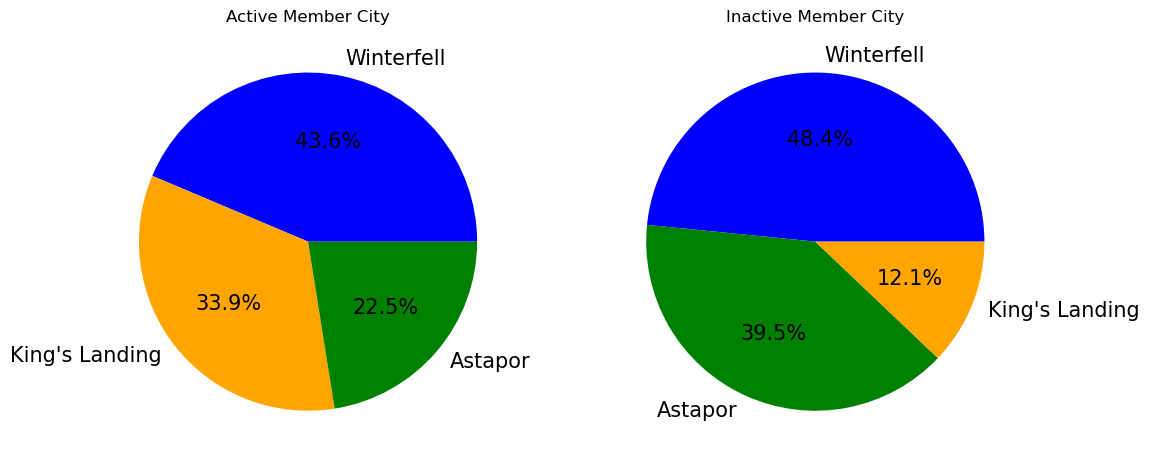

In [64]:
values1 = active.city.value_counts()
labels1 = ['Winterfell',"King's Landing","Astapor"]
colors1 = ['Blue','Orange','Green']

values2 = inactive.city.value_counts()
labels2 = ['Winterfell',"Astapor","King's Landing"]
colors2 = ['Blue','Green','Orange']

figs, (ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.pie(values1,labels=labels1,colors=colors1,autopct='%1.1f%%',textprops={'fontsize':15})
ax2.pie(values2,labels=labels2,colors=colors2,autopct='%1.1f%%',textprops={'fontsize':15})
ax1.set_title('Active Member City')
ax2.set_title('Inactive Member City')

plt.show()


* Much more use happening in King's Landing in 'Active' user dataset. -- potential for significant difference here. 

In [65]:
active.signup_date.value_counts()

2014-01-25    1094
2014-01-18    1065
2014-01-11     885
2014-01-24     836
2014-01-31     769
2014-01-17     755
2014-01-06     753
2014-01-10     739
2014-01-19     709
2014-01-01     699
2014-01-26     674
2014-01-04     634
2014-01-05     592
2014-01-23     573
2014-01-07     553
2014-01-09     532
2014-01-22     530
2014-01-16     517
2014-01-30     496
2014-01-28     495
2014-01-03     494
2014-01-27     485
2014-01-12     471
2014-01-21     462
2014-01-08     457
2014-01-29     440
2014-01-20     428
2014-01-14     406
2014-01-13     392
2014-01-15     372
2014-01-02     364
Name: signup_date, dtype: int64

In [66]:
inactive.signup_date.value_counts()

2014-01-18    1862
2014-01-25    1773
2014-01-11    1500
2014-01-24    1430
2014-01-17    1377
2014-01-31    1316
2014-01-19    1299
2014-01-10    1267
2014-01-01    1025
2014-01-23    1022
2014-01-26    1016
2014-01-06     989
2014-01-30     962
2014-01-07     924
2014-01-16     904
2014-01-09     888
2014-01-20     858
2014-01-12     854
2014-01-04     841
2014-01-22     826
2014-01-08     808
2014-01-28     776
2014-01-21     760
2014-01-29     751
2014-01-05     742
2014-01-27     738
2014-01-15     725
2014-01-14     708
2014-01-03     706
2014-01-13     650
2014-01-02     636
Name: signup_date, dtype: int64

* Same top two signup dates. 

In [67]:
active.phone.value_counts(normalize=True)

iPhone     0.831503
Android    0.168497
Name: phone, dtype: float64

In [68]:
inactive.phone.value_counts(normalize=True)

iPhone     0.616073
Android    0.383927
Name: phone, dtype: float64

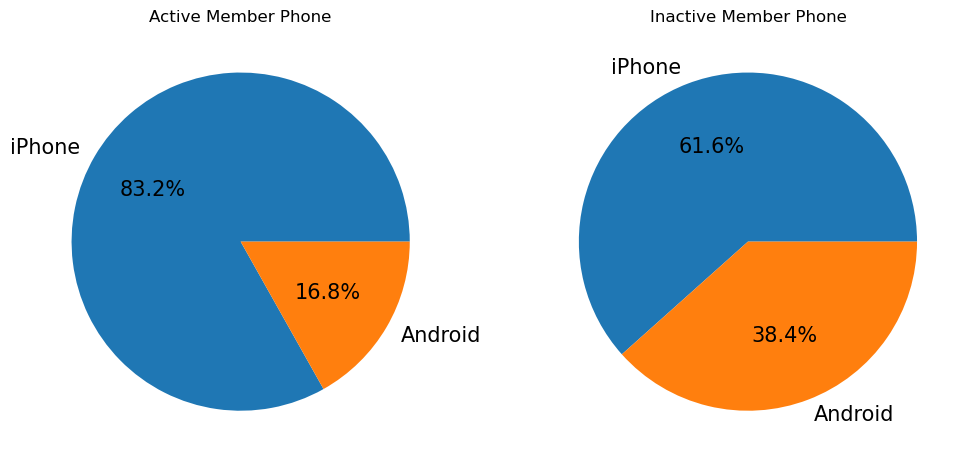

In [69]:
values1 = active.phone.value_counts()
labels1 = ['iPhone','Android']

values2 = inactive.phone.value_counts()
labels2 = ['iPhone','Android']

figs, (ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.pie(values1,labels=labels1,autopct='%1.1f%%',textprops={'fontsize':15})
ax2.pie(values2,labels=labels2,autopct='%1.1f%%',textprops={'fontsize':15})
ax1.set_title('Active Member Phone')
ax2.set_title('Inactive Member Phone')

plt.show()


* Seems to be many more Iphone users in the active user dataset. Both distributions are fairly large but it is much smaller for the inactive user dataset. 

In [70]:
active.ultimate_black_user.value_counts(normalize=True)

True     0.50399
False    0.49601
Name: ultimate_black_user, dtype: float64

In [71]:
inactive.ultimate_black_user.value_counts(normalize=True)

False    0.702518
True     0.297482
Name: ultimate_black_user, dtype: float64

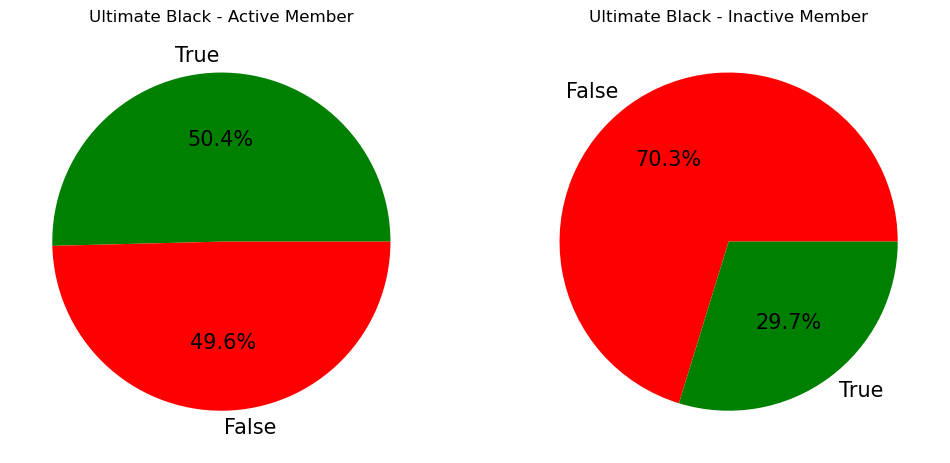

In [73]:
values1 = active.ultimate_black_user.value_counts()
labels1 = ['True','False']
colors1 = ['Green','Red']

values2 = inactive.ultimate_black_user.value_counts()
labels2 = ['False','True']
colors2 = ['Red','Green']

figs, (ax1,ax2) = plt.subplots(1,2,figsize=(12,12))
ax1.pie(values1,labels=labels1,colors=colors1,autopct='%1.1f%%',textprops={'fontsize':15})
ax2.pie(values2,labels=labels2,colors = colors2,autopct='%1.1f%%',textprops={'fontsize':15})
ax1.set_title('Ultimate Black - Active Member')
ax2.set_title('Ultimate Black - Inactive Member')

plt.show()


* MANY more ultimate black users in the active user dataset. 

Since our User activity columns tells us what we need to know about the users last trip, we'll drop that column. Signup date does not seem important since the top days were similar. 

In [74]:
df.drop(columns=['signup_date','last_trip_date'],inplace=True)

In [75]:
df

city  trips_in_first_30_days  avg_rating_of_driver  \
0      King's Landing                       4              4.700000   
1             Astapor                       0              5.000000   
2             Astapor                       3              4.300000   
3      King's Landing                       9              4.600000   
4          Winterfell                      14              4.400000   
...               ...                     ...                   ...   
49995  King's Landing                       0              5.000000   
49996         Astapor                       1              4.601559   
49997      Winterfell                       0              5.000000   
49998         Astapor                       2              3.000000   
49999         Astapor                       0              4.601559   

       avg_surge    phone  surge_pct  ultimate_black_user  weekday_pct  \
0           1.10   iPhone       15.4                 True         46.2   
1           1.00  Android        0.0                False         50.0   
2           1.00   iPhone        0.0                False        100.0   
3           1.14   iPhone       20.0                 True         80.0   
4           1.19  Android       11.8                False         82.4   
...          ...      ...        ...                  ...          ...   
49995       1.00   iPhone        0.0                False        100.0   
49996       1.00   iPhone        0.0                False          0.0   
49997       1.00  Android        0.0                 True        100.0   
49998       1.00   iPhone        0.0                False        100.0   
49999       1.00  Android        0.0                False          0.0   

       avg_dist  avg_rating_by_driver User_Activity  
0          3.67                   5.0        Active  
1          8.26                   5.0      Inactive  
2          0.77                   5.0      Inactive  
3          2.36                   4.9        Active  
4          3.13                   4.9      Inactive  
...         ...                   ...           ...  
49995      5.63                   4.2        Active  
49996      0.00                   4.0      Inactive  
49997      3.86                   5.0      Inactive  
49998      4.58                   3.5      Inactive  
49999      3.49                   5.0      Inactive  

[49604 rows x 11 columns]

## Checking for Feature Importance: 

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [77]:
X = pd.get_dummies(df, columns=['city','phone','ultimate_black_user']).drop('User_Activity',axis=1)
y = df.User_Activity

In [78]:
X

trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
0                           4              4.700000       1.10       15.4   
1                           0              5.000000       1.00        0.0   
2                           3              4.300000       1.00        0.0   
3                           9              4.600000       1.14       20.0   
4                          14              4.400000       1.19       11.8   
...                       ...                   ...        ...        ...   
49995                       0              5.000000       1.00        0.0   
49996                       1              4.601559       1.00        0.0   
49997                       0              5.000000       1.00        0.0   
49998                       2              3.000000       1.00        0.0   
49999                       0              4.601559       1.00        0.0   

       weekday_pct  avg_dist  avg_rating_by_driver  city_Astapor  \
0             46.2      3.67                   5.0             0   
1             50.0      8.26                   5.0             1   
2            100.0      0.77                   5.0             1   
3             80.0      2.36                   4.9             0   
4             82.4      3.13                   4.9             0   
...            ...       ...                   ...           ...   
49995        100.0      5.63                   4.2             0   
49996          0.0      0.00                   4.0             1   
49997        100.0      3.86                   5.0             0   
49998        100.0      4.58                   3.5             1   
49999          0.0      3.49                   5.0             1   

       city_King's Landing  city_Winterfell  phone_Android  phone_iPhone  \
0                        1                0              0             1   
1                        0                0              1             0   
2                        0                0              0             1   
3                        1                0              0             1   
4                        0                1              1             0   
...                    ...              ...            ...           ...   
49995                    1                0              0             1   
49996                    0                0              0             1   
49997                    0                1              1             0   
49998                    0                0              0             1   
49999                    0                0              1             0   

       ultimate_black_user_False  ultimate_black_user_True  
0                              0                         1  
1                              1                         0  
2                              1                         0  
3                              0                         1  
4                              1                         0  
...                          ...                       ...  
49995                          1                         0  
49996                          1                         0  
49997                          0                         1  
49998                          1                         0  
49999                          1                         0  

[49604 rows x 14 columns]

In [79]:
scaler = StandardScaler()

model = RandomForestClassifier()

model.fit(scaler.fit_transform(X),y)
importances = model.feature_importances_


In [80]:
importances 

array([0.07892661, 0.08083118, 0.06593803, 0.07859199, 0.13453502,
       0.30419045, 0.11277375, 0.01564747, 0.04849236, 0.01053107,
       0.01833189, 0.01908642, 0.01517014, 0.01695361])

In [81]:
scaled_df = pd.DataFrame.from_dict(dict(zip(X.columns,importances)),orient = 'index',columns = ['importances'])
scaled_df

importances
trips_in_first_30_days        0.078927
avg_rating_of_driver          0.080831
avg_surge                     0.065938
surge_pct                     0.078592
weekday_pct                   0.134535
avg_dist                      0.304190
avg_rating_by_driver          0.112774
city_Astapor                  0.015647
city_King's Landing           0.048492
city_Winterfell               0.010531
phone_Android                 0.018332
phone_iPhone                  0.019086
ultimate_black_user_False     0.015170
ultimate_black_user_True      0.016954

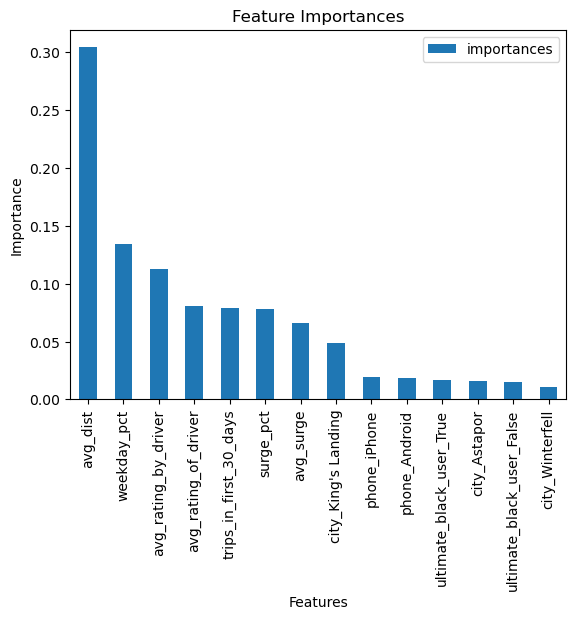

In [82]:
_= scaled_df.sort_values('importances',ascending = False).plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Looks like avg_distance is our most important feature, followed by % of trips occuring during a weekday and a user's average rating by a driver 

In [83]:
#Need to address how unbalanced our data is -- going to use SMOTE to adjust for this 

X = pd.get_dummies(df, columns=['city','phone','ultimate_black_user']).drop('User_Activity',axis=1)
y = df.User_Activity 

from imblearn.over_sampling import SMOTE
smote = SMOTE()
x_smote,y_smote = smote.fit_resample(X,y)

In [84]:
X_train,X_test,y_train,y_test = train_test_split(x_smote,y_smote,test_size=0.3,random_state=123)

In [85]:
n_estimators=[500,800,1500,2500,5000]
max_features = ['auto','sqrt','log2']
max_depth = [10,20,30,40,50]
max_depth.append(None)
min_samples_split = [2,5,10,15,20]
min_samples_leaf = [1,2,5,10,15]
grid_param = {'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}


In [298]:
RF_random = RandomizedSearchCV(estimator = model, param_distributions = grid_param, n_iter=500, cv=5, verbose=2,random_state=111,n_jobs=-1)
RF_random.fit(X_train,y_train)
RF_random.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


{'n_estimators': 5000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20}

In [86]:
RF_model = RandomForestClassifier(n_estimators=5000,min_samples_split=2,min_samples_leaf=2,max_features='sqrt',max_depth=20)


In [87]:
RF_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                       n_estimators=5000)

In [88]:
rf_predict = RF_model.predict(X_test)

In [89]:
rf_probs = RF_model.predict_proba(X_test)[:,1]

In [90]:
roc_value = roc_auc_score(y_test,rf_probs)
roc_value

0.8910445533772553

In [91]:
tn,fp,fn,tp = confusion_matrix(y_test,rf_predict).ravel()
print(tn,fp,fn,tp)

7395 1863 1698 7604


In [97]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score

In [93]:
from sklearn.model_selection import GridSearchCV

clf = LogisticRegression(class_weight='balanced')
Cs = {'C':[0.001,0.1,1,10,100]}
model = GridSearchCV(clf,Cs,cv=5,scoring='accuracy')
model.fit(X_train,y_train)
model.best_estimator_,model.best_score_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

(LogisticRegression(C=0.1, class_weight='balanced'), 0.7122570142549114)

In [94]:
clf = LogisticRegression(C=0.1)

In [95]:
clf.fit(X_train,y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [96]:
y_predlr = clf.predict(X_test)

In [98]:
accscore = accuracy_score(y_predlr,y_test)
print('Accuracy score:',accscore)

Accuracy score: 0.7078125


In [100]:
from sklearn.metrics import confusion_matrix

tn,fp,fn,tp = confusion_matrix(y_test,y_predlr).ravel()
print(tn,fp,fn,tp)

6200 3058 2365 6937


### Model Summary 

After exploring our data we discovered that avg_distance is our most important feature, followed by % of trips occuring during a weekday and a user's average rating by a driver. These are factors that need to be taken into consideration when trying to establish some sort of program that will increase/maintain retained members. For avg_distance I would focus on keeping costs down so that these users will continue to choose our services -- once prices go too high users might not consider using the service for longer distances. Maybe offer a discount for those who take multiple trips a week? It does look like users who are more courteous to drivers tend to be retained -- higher average ratings by drivers. We only tested two models here but it came out that RandomForest was our best bet. Accuracy score was much higher and looking at precision/recall through our confusion matrix it looks like it's a no brainer to choose RF over Logistic Regression. 